In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math
pylab.rcParams['figure.figsize'] = (8.25, 6)

In [2]:
# Import data
tor_df = pd.read_csv("../tornadoesr/data/raw/tor_train_set_no_zeros.csv")

# Seperating variables
# The outcomes
tornado_outcome = tor_df.iloc[:, [2]]

# The predictors
tornado_predictors = tor_df.iloc[:, 3:]

In [3]:
tor_data = tor_df.iloc[:, 2:].values
tor_data = Variable(torch.from_numpy(tor_data).type(torch.FloatTensor))

In [4]:
# Define the neural network
class BestNN(torch.nn.Module):
    
    def __init__(self):
        super(BestNN, self).__init__()
        self.fc1 = torch.nn.Linear(tornado_predictors.shape[1], 50)
        self.fc2 = torch.nn.Linear(50, 50)
        self.fc3 = torch.nn.Linear(50, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)


# Make it
bestnn = BestNN()

In [5]:
import pyro
from pyro.distributions import Normal, LogNormal, Pareto
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

# Normal Distribution Priors

In [6]:
def model(data):
    
    
    # First layer
    #    We have 51 input variables that go to 50 hidden units (51*50)
    weights_scale_first, weights_alpha_first = (0 * torch.ones(1, tornado_predictors.shape[1]*50),
                                                (1 * torch.ones(1, tornado_predictors.shape[1]*50)))
    #    We have 1 intercept per hidden unit (1*50)
    bias_scale_first, bias_alpha_first = (0 * torch.ones(1, 1*50),
                                          (1 * torch.ones(1, 1*50)))
    
    # Second layer
    #    We have 50 hidden activations that go to 1 output unit
    weights_scale_second, weights_alpha_second = (0 * torch.ones(1, 50*50),
                                                  (1 * torch.ones(1, 50*50)))
    #    We have 1 intercept per output unit (1)
    bias_scale_second, bias_alpha_second = (0 * torch.ones(1, 50*1),
                                            1 * torch.ones(1, 50*1))
    
    # Third layer
    #    We have 50 hidden activations that go to 1 output unit
    weights_scale_third, weights_alpha_third = (0 * torch.ones(1, 1*50),
                                                  (1 * torch.ones(1, 1*50)))
    #    We have 1 intercept per output unit (1)
    bias_scale_third, bias_alpha_third = (0 * torch.ones(1, 1*1),
                                            1 * torch.ones(1, 1*1))
    
    
    # For the first layer
    #    Creating and assigning the prior distributions for the weights
    w_priors_first = Normal(weights_scale_first, weights_alpha_first).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_first = Normal(bias_scale_first, bias_alpha_first).independent(1)
    
    # For the second layer
    #    Creating and assiging the prior distributions for the weights
    w_priors_second = Normal(weights_scale_second, weights_alpha_second).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_second = Normal(bias_scale_second, bias_alpha_second).independent(1)
    
    # For the third layer
    #    Creating and assiging the prior distributions for the weights
    w_priors_third = Normal(weights_scale_third, weights_alpha_third).independent(1)
    #    Creating and assigning the prior distribution for the intercepts
    b_prior_third = Normal(bias_scale_third, bias_alpha_third).independent(1)
    
    
    # Putting those into a dictionary
    priors = {'linear.weights_first': w_priors_first,
              'linear.bias_first': b_prior_first,
              'linear.weights_second': w_priors_second,
              'linear.bias_second': b_prior_second,
              'linear.weights_third': w_priors_third,
              'linear.bias_third': b_prior_third}
    
    
    # lift module parameters to random variables sampled from the priors
    # This is like creating the nn.Module (analogy to PyTorch)
    lifted_module = pyro.random_module("module", bestnn, priors)
    # sample a regressor (which also samples w and b)
    # This is like calling the nn.Module (analogy to PyTorch)
    lifted_nn_model = lifted_module()
    
    
    with pyro.iarange("map", 51):
        x_data = tor_data[:, 1:]
        y_data = tor_data[:, 0]

        # run the regressor forward conditioned on data
        prediction_mean = lifted_nn_model(x_data).squeeze(-1)
        
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, 0.1 * torch.ones(data.size(0))),
                    obs=y_data)

Inspect the following chunk, I'm suspicious of the "sig_n" parameters because they seems to be providing a 2nd parameter to the distributions which is likely messing up my Pareto/LogNormal distributions.

In [7]:
softplus = torch.nn.Softplus()
tanh = torch.nn.Tanh()

def guide(data):
    
    
    # First layer
    #     The weights
    w_scales_first = torch.randn(1, tornado_predictors.shape[1]*50)
    w_log_sigs_first = torch.tensor(-3.0 * torch.ones(1, tornado_predictors.shape[1]*50) + 0.05 * torch.randn(1, tornado_predictors.shape[1]*50))
    #     The intercepts 
    b_scale_first = torch.randn(1, 1*50)
    b_log_sig_first = torch.tensor(-3.0 * torch.ones(1, 1*50) + 0.05 * torch.randn(1, 1*50))
    
    # Second layer
    #     The weights
    w_scales_second = torch.randn(1, 50*50)
    w_log_sigs_second = torch.tensor(-3.0 * torch.ones(1, 50*50) + 0.05 * torch.randn(1, 50*50))
    #     The intercepts 
    b_scale_second = torch.randn(1, 1*50)
    b_log_sig_second = torch.tensor(-3.0 * torch.ones(1, 1*50) + 0.05 * torch.randn(1, 1*50))
    
    # Third layer
    #     The weights
    w_scales_third = torch.randn(1, 50*1)
    w_log_sigs_third = torch.tensor(-3.0 * torch.ones(1, 50*1) + 0.05 * torch.randn(1, 50*1))
    #     The intercepts 
    b_scale_third = torch.randn(1, 1*1)
    b_log_sig_third = torch.tensor(-3.0 * torch.ones(1, 1*1) + 0.05 * torch.randn(1, 1*1))
    
    
    # Register learnable params in the param store
    # First layer
    #    The weights
    mw_params_first = pyro.param("guide_mean_weights_first", w_scales_first)
    sw_params_first = softplus(pyro.param("guide_log_alpha_weights_first", w_log_sigs_first))
    #    The intercepts
    mb_param_first = pyro.param("guide_mean_bias_first", b_scale_first)
    sb_param_first = softplus(pyro.param("guide_log_alpha_bias_first", b_log_sig_first))
    
    # Second layer
    #    The weights
    mw_params_second = pyro.param("guide_mean_weights_second", w_scales_second)
    sw_params_second = softplus(pyro.param("guide_log_alpha_weights_second", w_log_sigs_second))
    #    The intercepts
    mb_param_second = pyro.param("guide_mean_bias_second", b_scale_second)
    sb_param_second = softplus(pyro.param("guide_log_alpha_bias_second", b_log_sig_second))
    
    # Third layer
    #    The weights
    mw_params_third = pyro.param("guide_mean_weights_third", w_scales_third)
    sw_params_third = tanh(pyro.param("guide_log_weights_third", w_log_sigs_third))
    #    The intercepts
    mb_param_third = pyro.param("guide_mean_bias_third", b_scale_third)
    sb_param_third = tanh(pyro.param("guide_log_alpha-bias_second", b_log_sig_third))
    
    
    # guide distributions for w and b
    # First layer
    w_dists_first = Normal(mw_params_first, sw_params_first).independent(1)
    b_dist_first = Normal(mb_param_first, sb_param_first).independent(1)
    # Second layer
    w_dists_second = Normal(mw_params_second, sw_params_second).independent(1)
    b_dist_second = Normal(mb_param_second, sb_param_second).independent(1)
    # Third layer
    w_dists_third = Normal(mw_params_third, sw_params_third).independent(1)
    b_dist_third = Normal(mb_param_third, sb_param_third).independent(1)
    dists = {'linear.weights_first': w_dists_first,
             'linear.bias_first': b_dist_first,
             'linear.weights_second': w_dists_second,
             'linear.bias_second': b_dist_second,
             'linear.weights_third': w_dists_third,
             'linear.bias_second': b_dist_third}
    
    
    # overload the parameters in the module with random samples
    # from the guide distributions
    lifted_module = pyro.random_module("module", bestnn, dists)
    # sample a regressor (which also samples w and b)
    return lifted_module()

In [8]:
optim = Adam({"weight_decay": 1000})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [9]:
num_iterations = 1000
N = (tor_data.shape[1] - 1)

def main():
    pyro.clear_param_store()
    data_x = tornado_predictors
    data_y = tornado_outcome
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(tor_data)
        if (j) % 250 == 0:
            print("[iteration %04f] loss: %.4f" % ((j+1), loss / float(N)))

if __name__ == '__main__':
    main()

[iteration 1.000000] loss: 4146.2721
[iteration 251.000000] loss: 560.0843
[iteration 501.000000] loss: 479.5765
[iteration 751.000000] loss: 413.2050


In [10]:
# Import train data
train_df = pd.read_csv("../tornadoesr/data/raw/tor_train_set_no_zeros.csv")

# Partition the data
train_outcome = train_df.iloc[:, [2]].values
train_predictors = train_df.iloc[:, 3:].values

# Set it up
y_data = Variable(torch.from_numpy(train_outcome).type(torch.FloatTensor))
x_data = Variable(torch.from_numpy(train_predictors).type(torch.FloatTensor))

# Before evaluating
loss = torch.nn.MSELoss()
y_preds = torch.zeros(x_data.shape[0], 1)

stored_preds = np.zeros((100, y_data.shape[0]))

# Evaluating
num_samples_of_param = 100
for i in range(num_samples_of_param):
    # guide does not require the data
    sampled_reg_model = guide(None)
    
    # run the regression model and add prediction to total
    current_y_preds = sampled_reg_model(x_data)
    y_preds = y_preds + current_y_preds
    
    stored_preds[i, :] = current_y_preds.squeeze().data.numpy()
    
# take the average of the predictions
y_preds = y_preds / num_samples_of_param
print ("Loss: ", loss(y_preds, y_data).item())

Loss:  0.07157570123672485


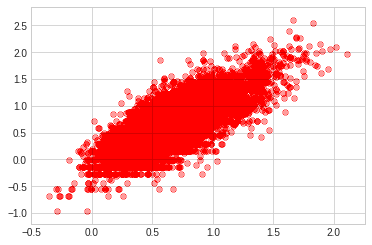

In [11]:
for i in range(num_samples_of_param):
    plt.scatter(x = stored_preds[i, :],
                y = y_data,
                alpha = 0.002,
                color = 'red');

In [12]:
# Import cross-validation data
cv_df = pd.read_csv("../tornadoesr/data/raw/tor_cv_set_no_zeros.csv")

# Partition the data
cv_outcome = cv_df.iloc[:, [2]].values
cv_predictors = cv_df.iloc[:, 3:].values

# Set it up
y_data = Variable(torch.from_numpy(cv_outcome).type(torch.FloatTensor))
x_data = Variable(torch.from_numpy(cv_predictors).type(torch.FloatTensor))

# Set it up
y_preds = torch.zeros(x_data.shape[0], 1)

stored_preds = np.zeros((100, y_data.shape[0]))

# Evaluating
num_samples_of_param = 100
for i in range(num_samples_of_param):
    # guide does not require the data
    sampled_reg_model = guide(None)
    
    # run the regression model and add prediction to total
    current_y_preds = sampled_reg_model(x_data)
    y_preds = y_preds + current_y_preds
    
    stored_preds[i, :] = current_y_preds.squeeze().data.numpy()
    
# take the average of the predictions
y_preds = y_preds / num_samples_of_param
print ("Loss: ", loss(y_preds, y_data).item())

Loss:  0.09371402114629745


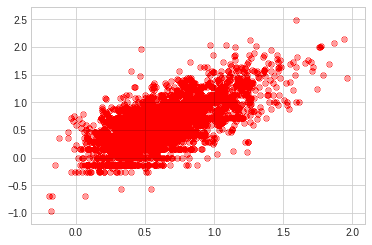

In [13]:
for i in range(num_samples_of_param):
    plt.scatter(x = stored_preds[i, :],
                y = y_data,
                alpha = 0.002,
                color = 'red');